# **Análise de dados com R**: Paradoxo de Simpson

<img src='https://www.unifor.br/o/unifor-theme/images/unifor-logo-horizontal.svg' width="250px">

**Prof. Ricardo Carubbi**<br>
Atualizado em 01/08/2023

## Equipe

##G2 -  Jean Diniz , San tiago, Daniel Ricarte, Gilmar

## Contexto
O paradoxo de Simpson é um fenômeno em probabilidade e estatística, em que uma tendência aparece na amostra total, mas desaparece ou reverte quando essa amostra é analisada de forma estratificada.

Um dos exemplos mais conhecidos do paradoxo de Simpson é um estudo de viés de gênero entre admissões de pós-graduação na Universidade da Califórnia, em Berkeley. Os números de admissão para o outono de 1973 mostraram que os homens que se candidatavam eram mais propensos do que as mulheres a serem admitidos, e a diferença era tão grande que era improvável que fosse devido ao acaso [1,2].</br>

Fontes:</br>
[1] David Freedman, Robert Pisani, and Roger Purves (2007), Statistics (4th edition), W. W. Norton. ISBN 0-393-92972-8.</br>
[2] Sex Bias in Graduate Admissions: Data From Berkeley» (PDF). Science. 187. PMID 17835295. doi:10.1126/science.187.4175.398</br>

## Objetivo
Comprovação do paradoxo de Simpson na análise de viés de gênero nos dados observacionais provindos da admissão de alunos por graduação e gênero da Universidade de Berkeley em 1973.

## Metodologia
Adotar um método simples e inteligente: **comparar o que é comparável**.

1. Definir as taxas de admissão na **amostra total**.
2. Definir as taxas de admissão nos **estratos das graduações**.
3. Verificar, de forma simples, a presença do paradoxo de Simpson ao constatar que o resultado na amostra total **difere** nos estratos populacionais.

## Observações
1. Adotar uma diferença entre as taxas de admissão por gênero de 2.5% como sendo **estatisticamente significante**. Valores iguais ou maiores indicam uma diferença siginificante. Menores valores indicam insiginifcância estatística, ou seja, não há diferenças siginificantes entre as taxas de admissão.
2. O paradoxo de Simpson é verificado pela **diferença ou pela ausência de significância** dos resultados.
3. Análises fora do escopo desse trabalho serão consideradas **nulas**.
4. Não será admitido uso de **pacotes além dos pré-instaldos**.
5. Uso de funções é **incentivado** e recompensado contudo não obrigatório.

## Avaliação
Nota composta pela média ponderada do resultado e respectiva **interpretação**, legibilidade do código e organização do notebbok.

In [123]:
#Install and load pacman
install.packages('pacman')
library("pacman")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [124]:
# Instala e/ou carraga demais pacotes
p_load('tidyverse','gridExtra','ggplot2')

## Funções

In [125]:
# Função que exibe os estratos do dataset
printStrata <- function(df,ref_var) {

    # Seleção de colunas categóricas
    cols <- colnames(df)
    cols <- cols[!cols %in% ref_var]

    # Lista de nomes de variáveis categóricas
    vars <- c()
    for (col in cols) {
        if (is.factor(df[,col])) {
            vars <- c(vars, col)
        }
    }

    # Verificação dos tamanhos amostrais dos estratos
    for (var in vars) {
        cat('\nEstratos de',var,':\n')
        print(table(df[,ref_var], df[,var]))
    }

}

In [126]:
# Função de balanceamento por subamostragem
balDataset <- function(df, var) {

    # Reprodução do resultado
    set.seed(1)

    # Condição da variável var
    lvar <- levels(df[,var])

    if (length(lvar) == 2) {

        # Separação em dataframes por categoria
        dfA <- df[df[,var] == lvar[1], ]
        dfB <- df[df[,var] == lvar[2], ]

        # Determina o tamanho da amostra
        ns <- min(nrow(dfA), nrow(dfB))

        # Subamostra dos dataframes
        dfA_sample <- dfA[sample(nrow(dfA), ns), ]
        dfB_sample <- dfB[sample(nrow(dfB), ns), ]

        # Junção dos dataframes
        tmp <- rbind(dfA_sample, dfB_sample)

        return(tmp)

    } else {
        cat(
            'Variável', var, 'possui', length(lvar), 'levels.',
            'Apenas variáveis com 2 levels são aceitas!'
        )
    }
}


In [127]:
# Função para criar uma tabela com valores absolutos e relativos
supertable <- function(df,var) {
    tab <- table(df[,var])
    print(tab)
    round(prop.table(tab)*100,2)
}

In [128]:
# Função para criar uma tabela com valores absolutos e relativos, p/ 2 variáveis
supertable2 <- function(df,var,var2) {
    tabH <- table(df[,var], df[,var2])
    tabH
    propH <- prop.table(tabH, margin = 2)
    round(propH*100,2)
}

In [129]:
analyse_gender <- function(data) {

    # Criando um vetor único para os gêneros
    genders <- unique(data$Gender)

    # Inicializando um dataframe vazio para os resultados
    results <- data.frame(Gender=character(),
                          Total=integer(),
                          Accepted=integer(),
                          Rejected=integer(),
                          Admission_Rate=numeric(),
                          stringsAsFactors=FALSE)

    # Loop para calcular os valores para cada gênero
    for (gender in genders) {

        gender_data <- data[data$Gender == gender, ]

        Total <- nrow(gender_data)
        Accepted <- sum(gender_data$Admission == "Accepted")
        Rejected <- sum(gender_data$Admission == "Rejected")
        Admission_Rate <- round((Accepted / Total) * 100, 2)

        # Adicionando os valores ao dataframe de resultados
        results <- rbind(results, data.frame(Gender=gender, Total=Total, Accepted=Accepted,
                                             Rejected=Rejected, Admission_Rate=Admission_Rate))
    }

    # Retornando o dataframe de resultados
    return(results)
}




In [130]:
admission_by_major <- function(data) {

    # Criando um vetor único para os majors
    majors <- sort(unique(data$Major))

    # Inicializando um dataframe vazio para os resultados
    results <- data.frame(Major=character(),
                          Total=integer(),
                          Accepted=integer(),
                          Rejected=integer(),
                          Admission_Rate=numeric(),
                          stringsAsFactors=FALSE)

    # Loop para calcular os valores para cada major
    for (major in majors) {

        major_data <- data[data$Major == major, ]

        Total <- nrow(major_data)
        Accepted <- sum(major_data$Admission == "Accepted")
        Rejected <- sum(major_data$Admission == "Rejected")
        Admission_Rate <- round((Accepted / Total) * 100, 2)

        # Adicionando os valores ao dataframe de resultados
        results <- rbind(results, data.frame(Major=major, Total=Total, Accepted=Accepted,
                                             Rejected=Rejected, Admission_Rate=Admission_Rate))
    }

    # Retornando o dataframe de resultados
    return(results)
}


In [131]:
Major_table <- function(data) {

    # Criando vetores únicos para os majors e gêneros
    majors <- sort(unique(data$Major))
    genders <- sort(unique(data$Gender))

    # Inicializando um dataframe vazio para os resultados
    results <- data.frame(Major=character(),
                          Gender=character(),
                          Total=integer(),
                          Accepted=integer(),
                          Rejected=integer(),
                          Admission_Rate=numeric(),
                          stringsAsFactors=FALSE)

    # Loop para calcular os valores para cada combinação de major e gênero
    for (major in majors) {
        for (gender in genders) {
            subset_data <- data[data$Major == major & data$Gender == gender, ]

            Total <- nrow(subset_data)
            Accepted <- sum(subset_data$Admission == "Accepted")
            Rejected <- sum(subset_data$Admission == "Rejected")
            Admission_Rate <- round((Accepted / Total) * 100, 2)

            # Adicionando os valores ao dataframe de resultados
            results <- rbind(results, data.frame(Major=major, Gender=gender, Total=Total, Accepted=Accepted,
                                                 Rejected=Rejected, Admission_Rate=Admission_Rate))
        }
    }

    # Retornando o dataframe de resultados
    return(results)
}



In [132]:
# Reporta as frequências de admissão por gênero e graduação
analyse_major <- function(data, strat) {

  # Filtra os dados para o Major especificado
  major_data <- data[data$Major == strat, ]

  # Cria um vetor único dos gêneros presentes nos dados
  genders <- unique(major_data$Gender)

  # Inicializa uma lista para armazenar os resultados
  results <- list()

  for (gender in genders) {

    # Filtra os dados para o gênero atual
    gender_data <- major_data[major_data$Gender == gender, ]

    # Calcula as estatísticas desejadas
    Total <- nrow(gender_data)
    Accepted <- sum(gender_data$Admission == "Accepted")
    Rejected <- sum(gender_data$Admission == "Rejected")
    Admission_Rate <- round((Accepted / Total) * 100, 2)

    # Adiciona os resultados à lista
    results[[gender]] <- data.frame(
      Gender = gender,
      Total = Total,
      Accepted = Accepted,
      Rejected = Rejected,
      Admission_Rate = Admission_Rate
    )
  }

  # Combina os dataframes na lista em um único dataframe
  result_df <- do.call(rbind, results)

  return(result_df)
}


In [133]:
# Reporta graficamente as taxas de admissão por gênero e graduação

plot_major <- function(data,strat) {

  # Filtra os dados para Major "A"
  major_data <- subset(data, Major == strat)

  # Cria tabela de frequência de admissões por gênero
  contador <- table(major_data$Gender, major_data$Admission)

  # Criação do gráfico
  colors <- c("pink", "cyan") # Cores para Rejected e Accepted, respectivamente
  barplot(contador, beside = TRUE, col = colors, ylim = c(0, max(contador)*1.1),
          main = paste("Análise de Admissões no Major", strat, "por Gênero"),
          xlab = "Gênero",
          ylab = "Contagem de Admissões",
          legend.text = rownames(contador))}

In [134]:
pie_major <- function(data, strat) {

  # Filtra os dados para o Major escolhido
  major_data <- subset(data, Major == strat)

  # Calcula proporção de admissão por gênero
  female_prop <- prop.table(table(major_data$Admission[major_data$Gender == "F"]))
  male_prop <- prop.table(table(major_data$Admission[major_data$Gender == "M"]))

  # Cores para "Rejected" e "Accepted"
  colors <- c("green", "red")

  # Configura a disposição dos gráficos
  par(mfrow = c(1, 2))

  # Gráfico de pizza para mulheres
  pie(female_prop,
      labels = sprintf("%0.2f%%", female_prop * 100),
      col = colors,
      main = paste("Mulheres - Major", strat))

  # Gráfico de pizza para homens
  pie(male_prop,
      labels = sprintf("%0.2f%%", male_prop * 100),
      col = colors,
      main = paste("Homens - Major", strat))


}

## Carregamento do dados

In [135]:
# Download de arquivos do Google Drive.
# Link: https://drive.google.com/file/d/1Bdyyqf2SkrspQcvrRT-Q74CQHQ0M5zWG/view?usp=sharing

system('gdown --id 1Bdyyqf2SkrspQcvrRT-Q74CQHQ0M5zWG')

In [136]:
# Carrega o arquivos 'csv' separados por ','

berkeley <- read.csv(
    'berkeley.csv',
    sep = ',',
    colClasses = 'character')


In [137]:
# Exibe as primeiras linhas do dataframe
head(berkeley,10)

,Year,Major,Gender,Admission
,<chr>,<chr>,<chr>,<chr>
1,1973,C,F,Rejected
2,1973,B,M,Accepted
3,1973,Other,F,Accepted
4,1973,Other,M,Accepted
5,1973,Other,M,Rejected
6,1973,Other,M,Rejected
7,1973,F,F,Accepted
8,1973,Other,M,Accepted
9,1973,Other,M,Rejected


In [138]:
# Dados estruturais do dataframe
str(berkeley)

'data.frame':	12763 obs. of  4 variables:
 $ Year     : chr  "1973" "1973" "1973" "1973" ...
 $ Major    : chr  "C" "B" "Other" "Other" ...
 $ Gender   : chr  "F" "M" "F" "M" ...
 $ Admission: chr  "Rejected" "Accepted" "Accepted" "Accepted" ...


In [139]:
summary(berkeley)

     Year              Major              Gender           Admission        
 Length:12763       Length:12763       Length:12763       Length:12763      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [140]:
# Verificando valores NA
sum(is.na(berkeley))

[1] 0

## Pré-processamento

In [141]:
# Alteração do tipo de dados (coluna YEAR)
berkeley$Year <- as.integer(berkeley$Year)

In [142]:
# Alterações do tipo de dados numa estrutura em laço (demais colunas)

for(column in names(berkeley)){
    if(column != 'Year'){
        berkeley[[column]]<- as.factor(berkeley[[column]])
    }
}

In [143]:
str(berkeley)

'data.frame':	12763 obs. of  4 variables:
 $ Year     : int  1973 1973 1973 1973 1973 1973 1973 1973 1973 1973 ...
 $ Major    : Factor w/ 7 levels "A","B","C","D",..: 3 2 7 7 7 7 6 7 7 1 ...
 $ Gender   : Factor w/ 2 levels "F","M": 1 2 1 2 2 2 1 2 2 2 ...
 $ Admission: Factor w/ 2 levels "Accepted","Rejected": 2 1 1 1 2 2 1 1 2 1 ...


In [144]:
summary(berkeley)

      Year        Major      Gender      Admission   
 Min.   :1973   A    :1246   F:4321   Accepted:5232  
 1st Qu.:1973   B    : 585   M:8442   Rejected:7531  
 Median :1973   C    : 918                           
 Mean   :1973   D    : 792                           
 3rd Qu.:1973   E    : 584                           
 Max.   :1973   F    : 714                           
                Other:7924                           

In [145]:
# Balanceamento dos dados

# Antes do Balanceamento
cat('\nAntes do Balanceamento\n')
cat('-------------------------------\n')
supertable(berkeley,'Gender')

berkeley_bal = balDataset(berkeley,'Gender')

cat('\nDepois do Balanceamento\n')
cat('-------------------------------\n')
supertable(berkeley_bal,'Gender')



Antes do Balanceamento
-------------------------------

   F    M 
4321 8442 



    F     M 
33.86 66.14 


Depois do Balanceamento
-------------------------------

   F    M 
4321 4321 



 F  M 
50 50 

## Amostra Total

###Análise numérica

In [146]:
# Informações gerais

cat('\nDados Não Balanceado\n')
cat('----------------------\n')
table(berkeley$Major)
table(berkeley$Gender)
table(berkeley$Admission)

cat('\nDados Balanceado\n')
cat('----------------------\n')
table(berkeley_bal$Major)
table(berkeley_bal$Gender)
table(berkeley_bal$Admission)


Dados Não Balanceado
----------------------



    A     B     C     D     E     F Other 
 1246   585   918   792   584   714  7924 


   F    M 
4321 8442 


Accepted Rejected 
    5232     7531 


Dados Balanceado
----------------------



    A     B     C     D     E     F Other 
  673   326   758   583   494   551  5257 


   F    M 
4321 4321 


Accepted Rejected 
    3410     5232 

In [147]:
# Criando um vetor único para os gêneros
cat('\nDados Não Balanceado\n')
cat('----------------------\n')
df_gender <- analyse_gender(berkeley)
analyse_gender(berkeley)
cat('\nDados Balanceado\n')
cat('----------------------\n')
df_gender_bal <- analyse_gender(berkeley_bal)
analyse_gender(berkeley_bal)


Dados Não Balanceado
----------------------


Gender,Total,Accepted,Rejected,Admission_Rate
<chr>,<int>,<int>,<int>,<dbl>
F,4321,1494,2827,34.58
M,8442,3738,4704,44.28



Dados Balanceado
----------------------


Gender,Total,Accepted,Rejected,Admission_Rate
<chr>,<int>,<int>,<int>,<dbl>
F,4321,1494,2827,34.58
M,4321,1916,2405,44.34


In [148]:
# Uso da função
cat('\nDados Não Balanceado\n')
cat('----------------------\n')
df_major <- admission_by_major(berkeley)
admission_by_major(berkeley)
cat('\nDados Balanceado\n')
cat('----------------------\n')
df_major_bal <- admission_by_major(berkeley_bal)
admission_by_major(berkeley_bal)


Dados Não Balanceado
----------------------


Major,Total,Accepted,Rejected,Admission_Rate
<chr>,<int>,<int>,<int>,<dbl>
A,1246,914,332,73.35
B,585,370,215,63.25
C,918,321,597,34.97
D,792,269,523,33.96
E,584,147,437,25.17
F,714,47,667,6.58
Other,7924,3164,4760,39.93



Dados Balanceado
----------------------


Major,Total,Accepted,Rejected,Admission_Rate
<chr>,<int>,<int>,<int>,<dbl>
A,673,510,163,75.78
B,326,201,125,61.66
C,758,264,494,34.83
D,583,206,377,35.33
E,494,118,376,23.89
F,551,35,516,6.35
Other,5257,2076,3181,39.49


In [149]:

cat('\nAnálise Relativa por Admission\n')
cat('-----------------------\n')
cat('Aceitos\n')
supertable2(subset(berkeley,Admission=='Accepted'), "Major", "Gender")
cat('\nRejeitados\n')
supertable2(subset(berkeley,Admission=='Rejected'), "Major", "Gender")



cat('\nAnálise Relativa por Admission (Balanceado)\n')
cat('-----------------------\n')
cat('Aceitos\n')
supertable2(subset(berkeley_bal,Admission=='Accepted'), "Major", "Gender")
cat('\nRejeitados\n')
supertable2(subset(berkeley_bal,Admission=='Rejected'), "Major", "Gender")


Análise Relativa por Admission
-----------------------
Aceitos


       
            F     M
  A      5.96 22.07
  B      1.14  9.44
  C     13.45  3.21
  D      8.77  3.69
  E      6.29  1.42
  F      1.67  0.59
  Other 62.72 59.58


Rejeitados


       
            F     M
  A      0.67  6.65
  B      0.28  4.40
  C     13.87  4.36
  D      8.63  5.93
  E     10.58  2.93
  F     11.18  7.46
  Other 54.79 68.26


Análise Relativa por Admission (Balanceado)
-----------------------
Aceitos


       
            F     M
  A      5.96 21.97
  B      1.14  9.60
  C     13.45  3.29
  D      8.77  3.91
  E      6.29  1.25
  F      1.67  0.52
  Other 62.72 59.45


Rejeitados


       
            F     M
  A      0.67  5.99
  B      0.28  4.86
  C     13.87  4.24
  D      8.63  5.53
  E     10.58  3.20
  F     11.18  8.32
  Other 54.79 67.86

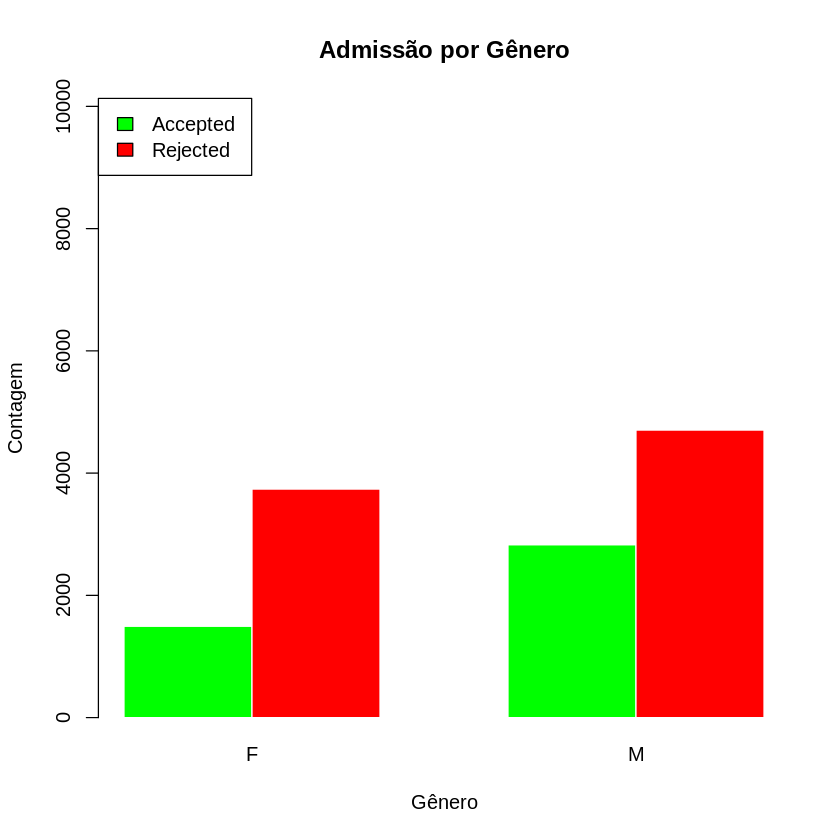

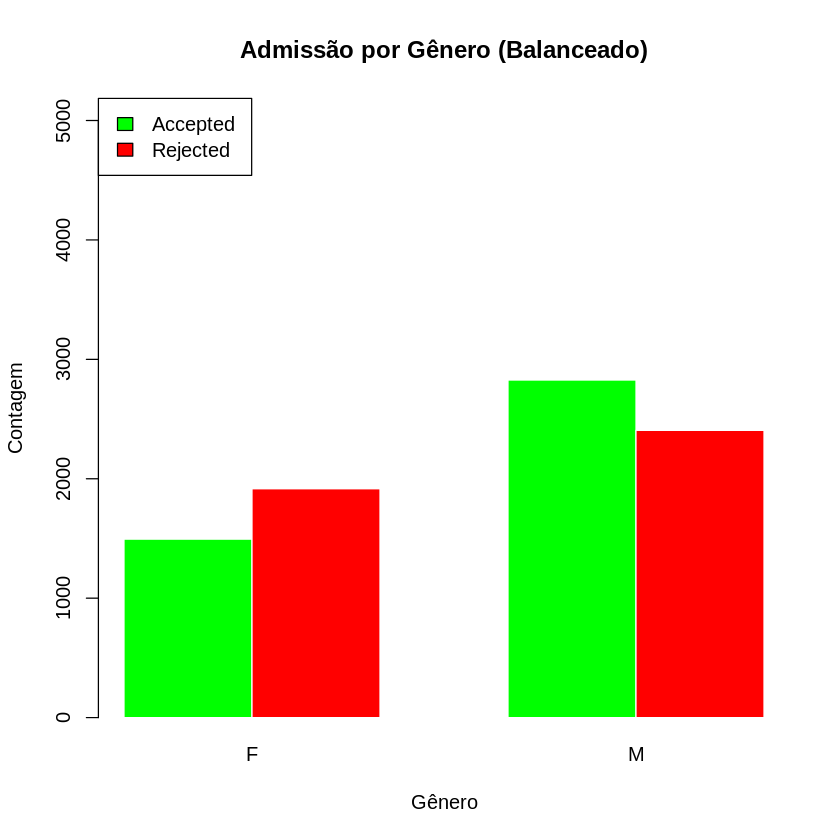

In [150]:
# Análise gráfica (Admissão por Gênero)


barplot(height = cbind(df_gender$Accepted, df_gender$Rejected),
        beside = TRUE,
        col = c('green','red'),
        ylim = c(0, max(df_gender$Total) * 1.2),
        main = "Admissão por Gênero",
        xlab = "Gênero",
        ylab = "Contagem",
        border = "white",
        names.arg = df_gender$Gender,
        legend.text = c("Accepted", "Rejected"),
        args.legend = list(x = "topleft"))

barplot(height = cbind(df_gender_bal$Accepted, df_gender_bal$Rejected),
        beside = TRUE,
        col = c('green','red'),
        ylim = c(0, max(df_gender_bal$Total) * 1.2),
        main = "Admissão por Gênero (Balanceado)",
        xlab = "Gênero",
        ylab = "Contagem",
        border = "white",
        names.arg = df_gender_bal$Gender,
        legend.text = c("Accepted", "Rejected"),
        args.legend = list(x = "topleft"))

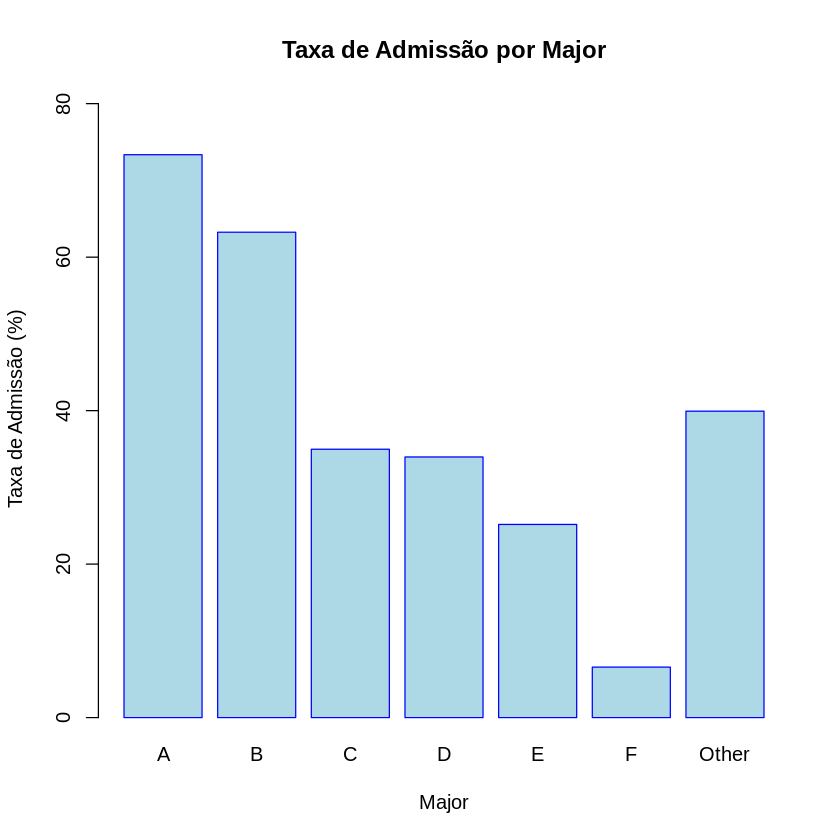

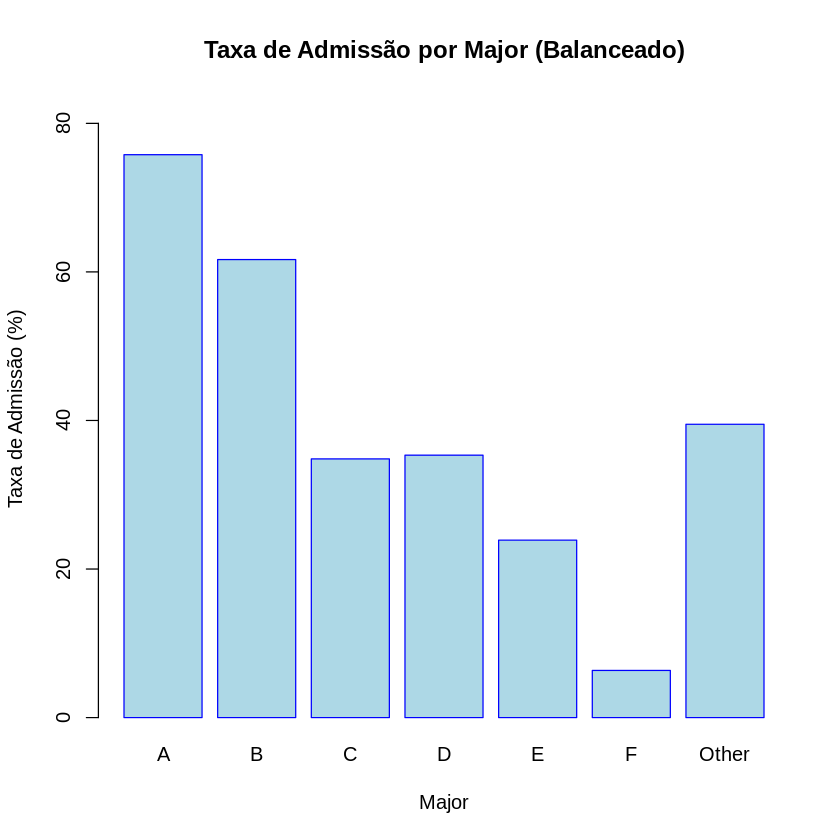

In [151]:

# Gráfico de barras (Taxa de Admissão por Major)
barplot(df_major$Admission_Rate,
        names.arg = df_major$Major,
        col = "lightblue",
        ylim = c(0, max(df_major$Admission_Rate) * 1.1),
        main = "Taxa de Admissão por Major",
        xlab = "Major",
        ylab = "Taxa de Admissão (%)",
        border = "blue")

# Gráfico de barras
barplot(df_major_bal$Admission_Rate,
        names.arg = df_major_bal$Major,
        col = "lightblue",
        ylim = c(0, max(df_major_bal$Admission_Rate) * 1.1),
        main = "Taxa de Admissão por Major (Balanceado)",
        xlab = "Major",
        ylab = "Taxa de Admissão (%)",
        border = "blue")

**Descreva e analise os resultados**

Os resultados nos mostram que, visto de uma perspectiva da amostra geral, que existe uma clara diferença entre as taxas de admissão, se analisadas de maneira relativa, para homens e mulheres. Um homem tem uma taxa de admissão 10% maior do que das mulheres sem nenhum motivo aparente aqui.

Outro dado interessante de pontuar são as características de admissão dos Majors, que possui uma tendencia decrescente. A taxa de admissão do MajorA é a maior, e a F é a menor, enquanto a Other(Outros Majors) possui uma taxa de 40%, estando numa média entre esses dois Majors.

## Major A

In [152]:
# Análise numérica

majorstrat <- 'A'

cat('\nAnálise Númerica do Major',majorstrat,' \n')
cat('---------------------------------\n')
analyse_major(berkeley, majorstrat)

cat('\nAnálise Númerica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')
analyse_major(berkeley_bal,majorstrat)


Análise Númerica do Major A  
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
M,M,1138,825,313,72.50
F,F,108,89,19,82.41



Análise Númerica do Major A  (Balanceado)
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
F,F,108,89,19,82.41
M,M,565,421,144,74.51



Análise Gráfica do Major A  
---------------------------------


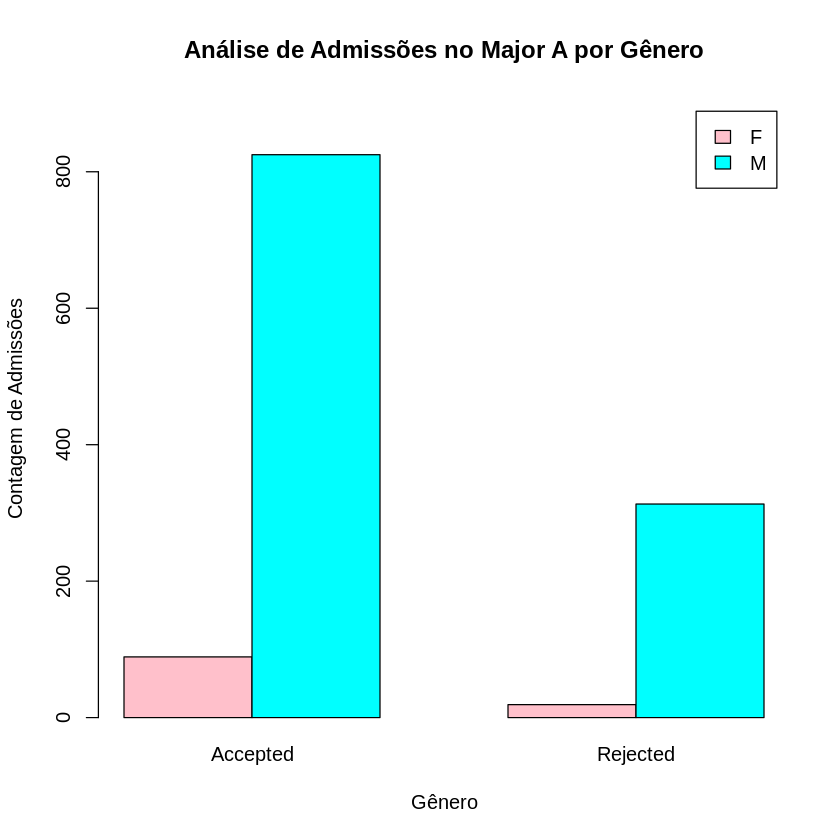


Análise Gráfica do Major A  (Balanceado)
---------------------------------


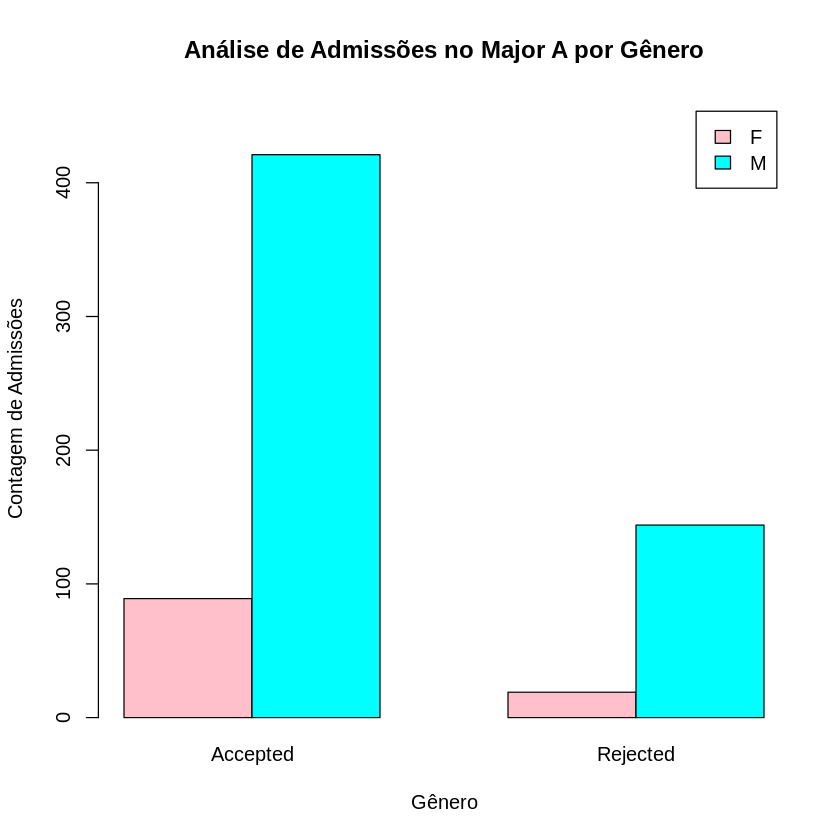

In [153]:
# Análise gráfica

cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
plot_major(berkeley,majorstrat)



plot_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')


Análise Gráfica do Major A  
---------------------------------


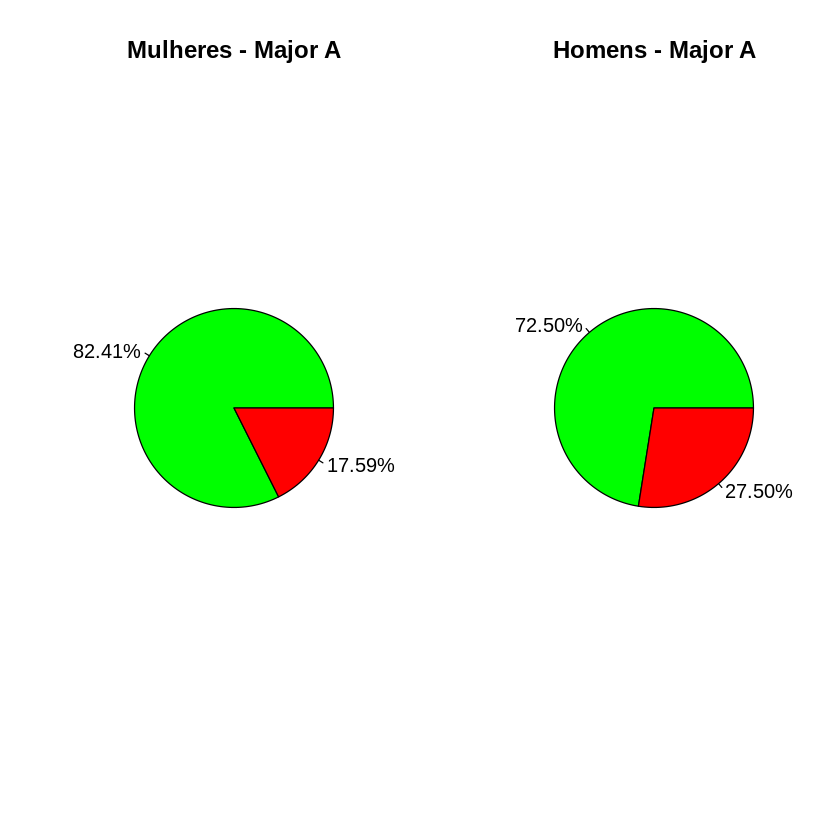


Análise Gráfica do Major A  
---------------------------------


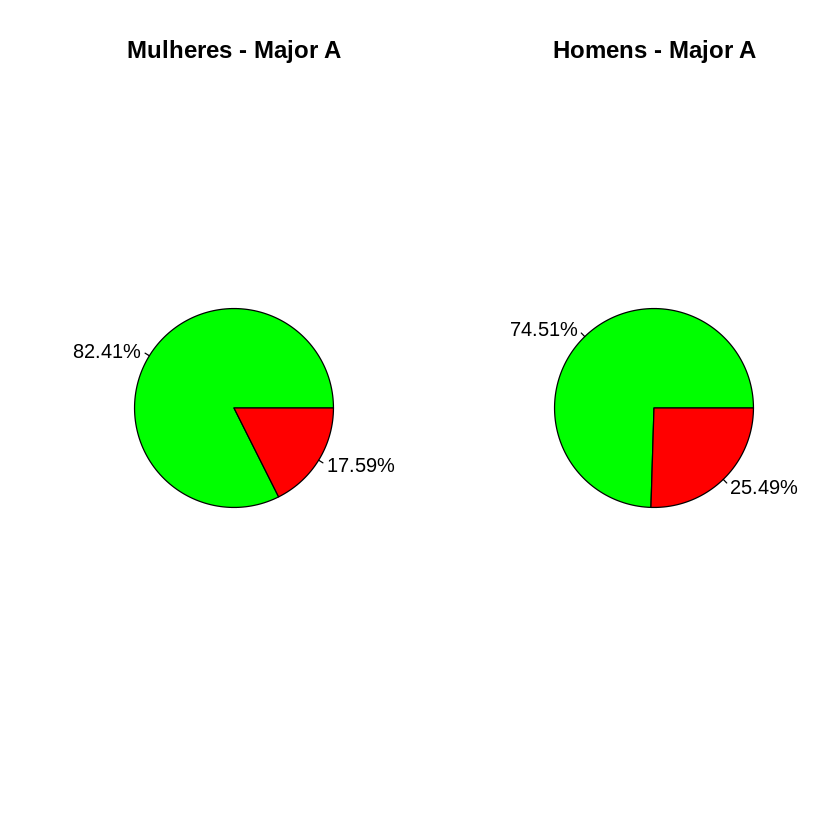

In [154]:
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
pie_major(berkeley,majorstrat)


pie_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')

**Descreva e analise os resultados**

Os resultados estratificados para o Major A apontam que Mulheres possuem uma taxa de admissão proporcional superior a dos Homens em quase 10%. Um valor bastante significativo.

## Major B

In [155]:
# Análise numérica

majorstrat <- 'B'

cat('\nAnálise Númerica do Major',majorstrat,' \n')
cat('---------------------------------\n')
analyse_major(berkeley, majorstrat)

cat('\nAnálise Númerica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')
analyse_major(berkeley_bal,majorstrat)




Análise Númerica do Major B  
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
M,M,560,353,207,63.04
F,F,25,17,8,68.00



Análise Númerica do Major B  (Balanceado)
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
F,F,25,17,8,68.00
M,M,301,184,117,61.13



Análise Gráfica do Major B  
---------------------------------


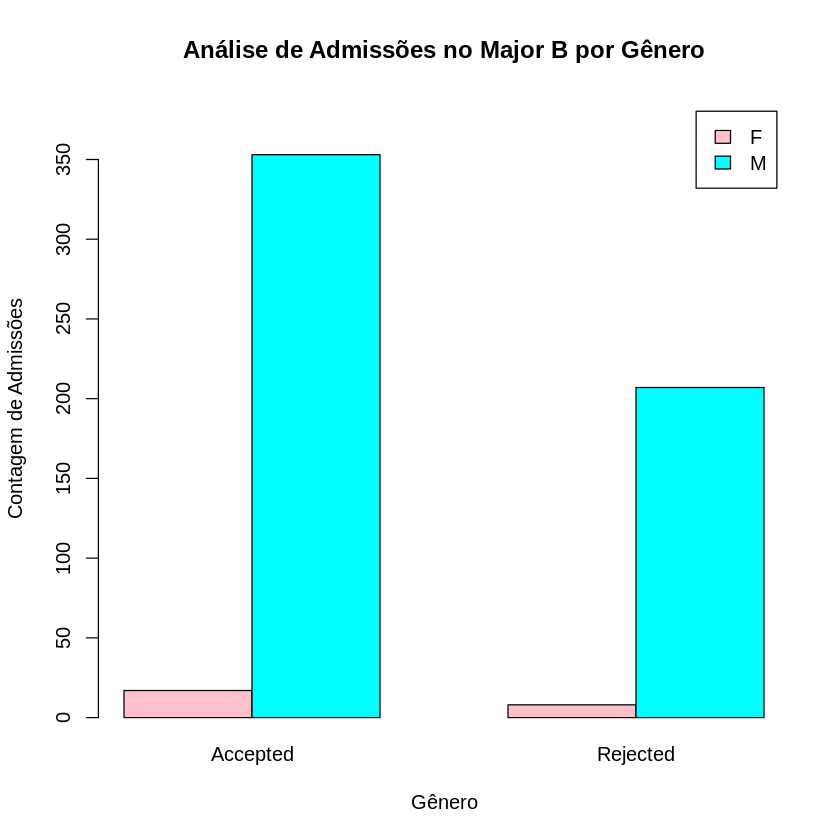


Análise Gráfica do Major B  (Balanceado)
---------------------------------


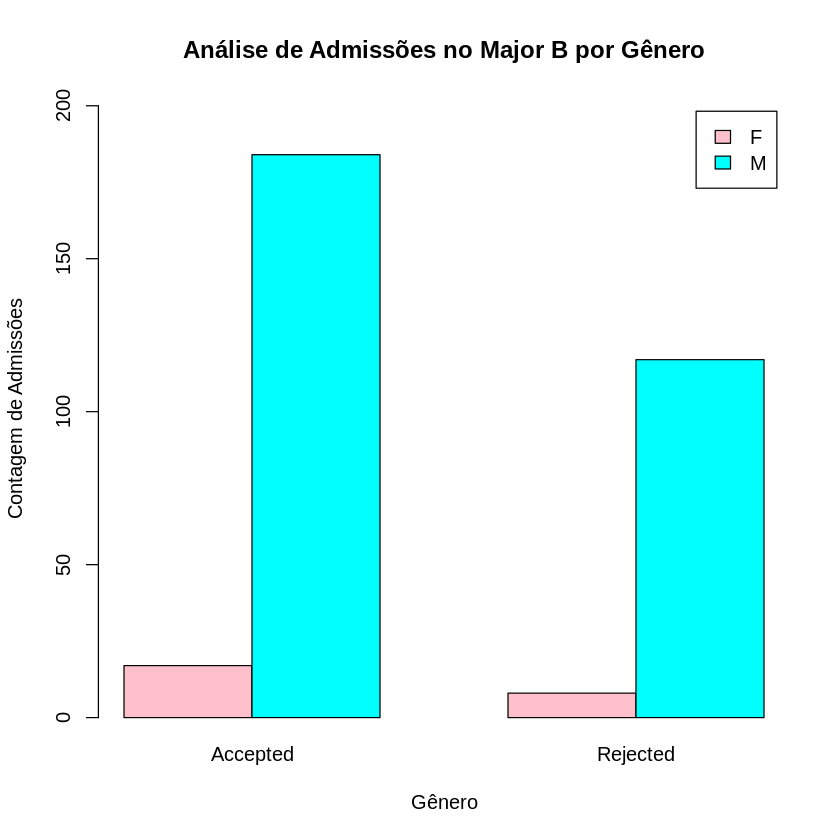

In [156]:
# Análise gráfica

cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
plot_major(berkeley,majorstrat)



plot_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')


Análise Gráfica do Major B  
---------------------------------


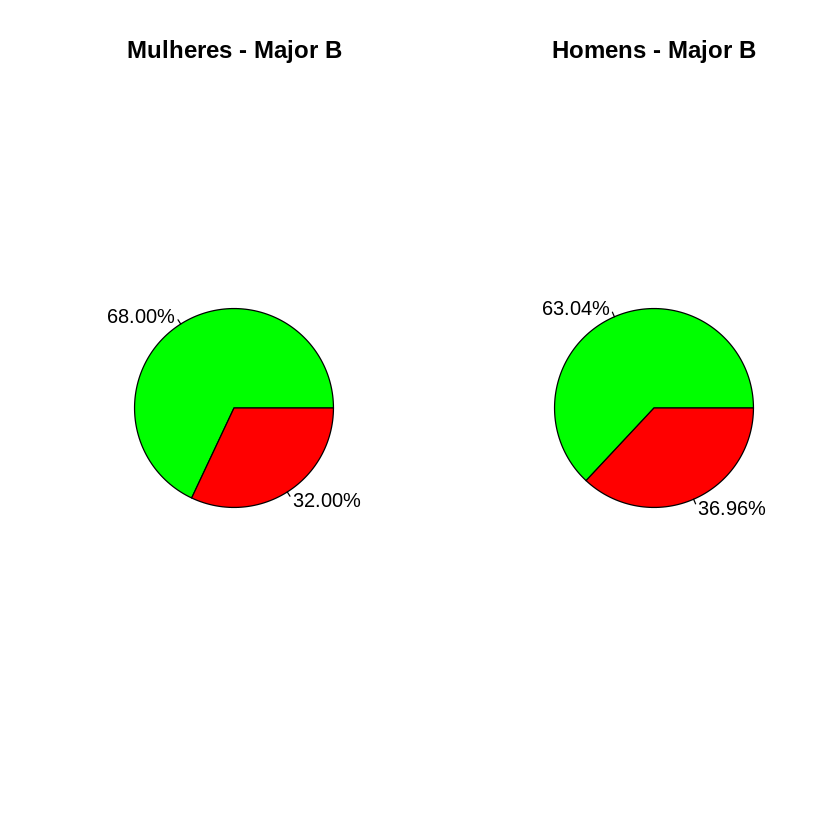


Análise Gráfica do Major B  
---------------------------------


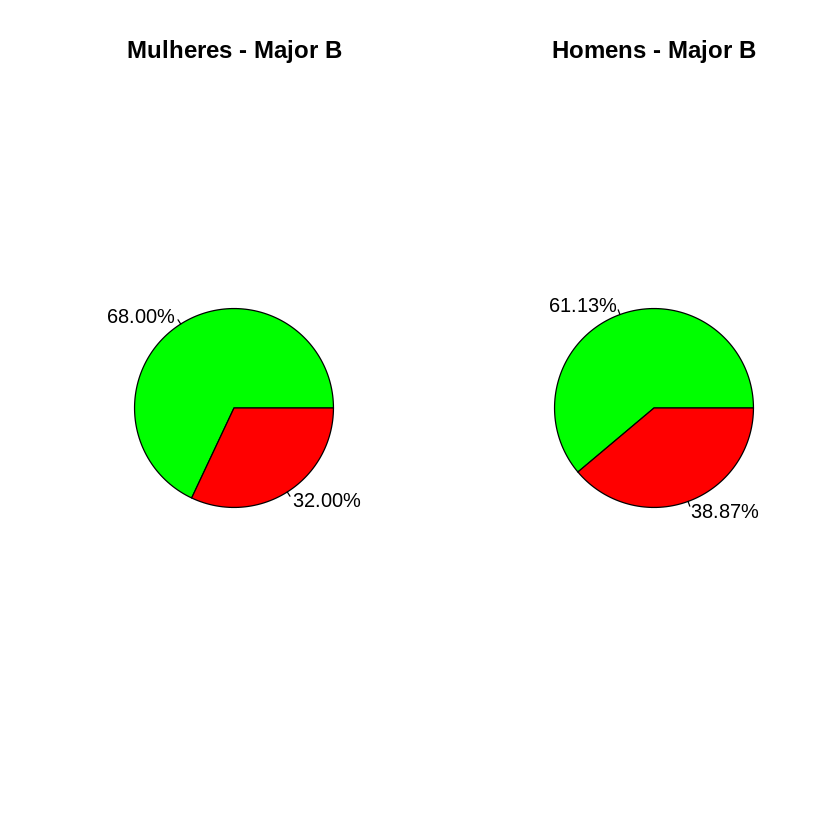

In [157]:
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
pie_major(berkeley,majorstrat)


pie_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')

**Descreva e analise os resultados**

Os resultados estratificados para o Major B apontam que Homens possuem uma taxa de admissão proporcional superior a das Mulheres em quase 7%. Um valor bastante significativo.

## Major C

In [158]:
# Análise numérica

majorstrat <- 'C'

cat('\nAnálise Númerica do Major',majorstrat,' \n')
cat('---------------------------------\n')
analyse_major(berkeley, majorstrat)

cat('\nAnálise Númerica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')
analyse_major(berkeley_bal,majorstrat)


Análise Númerica do Major C  
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
F,F,593,201,392,33.90
M,M,325,120,205,36.92



Análise Númerica do Major C  (Balanceado)
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
F,F,593,201,392,33.90
M,M,165,63,102,38.18



Análise Gráfica do Major C  
---------------------------------


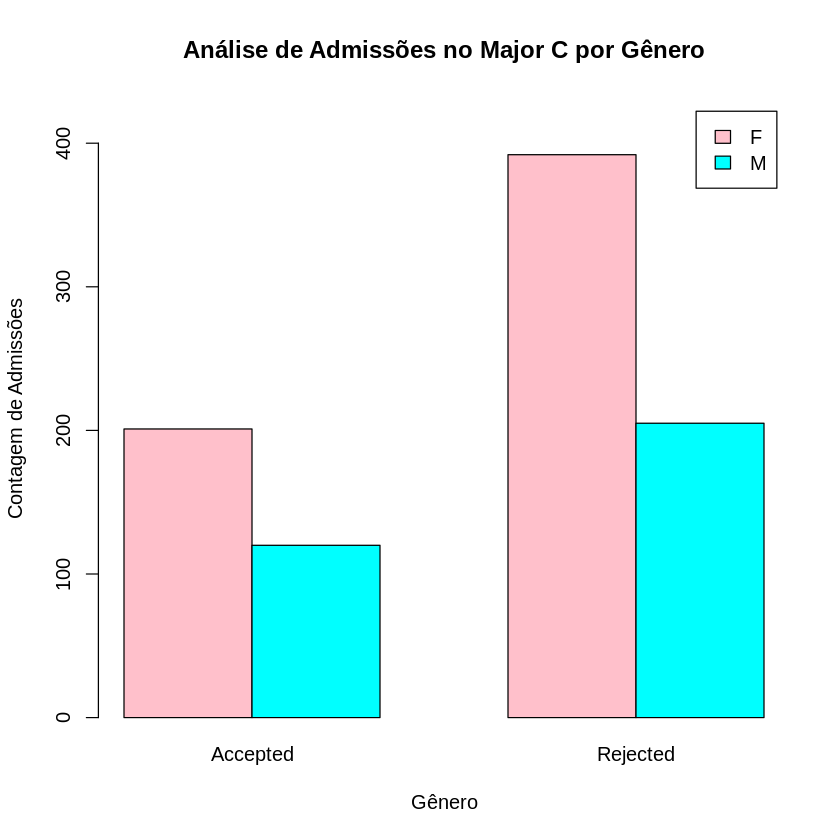


Análise Gráfica do Major C  (Balanceado)
---------------------------------


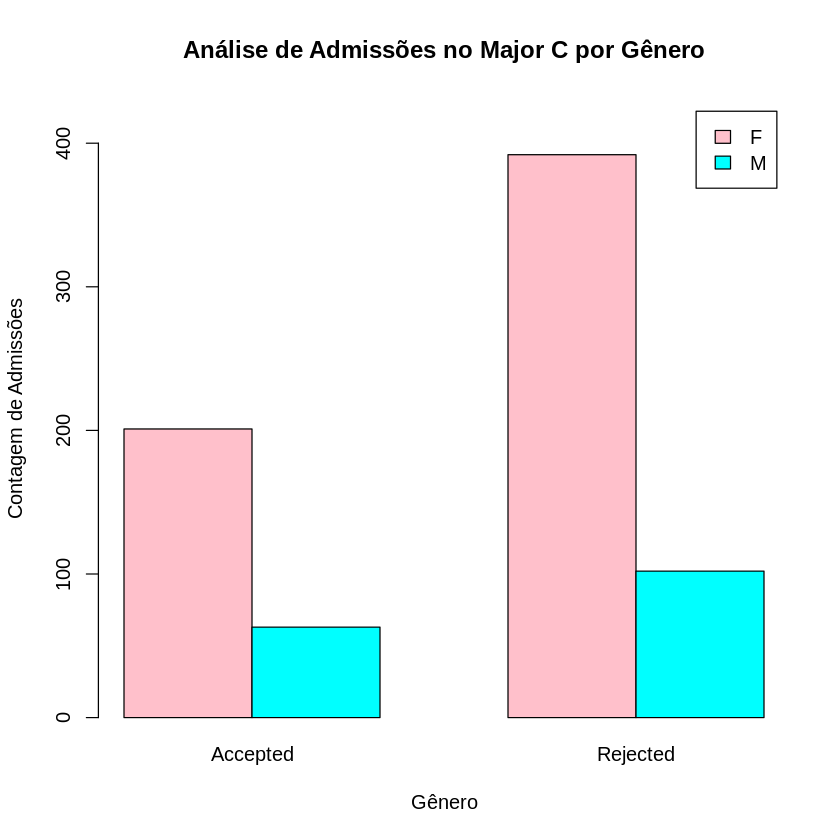

In [159]:
# Análise gráfica

cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
plot_major(berkeley,majorstrat)



plot_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')


Análise Gráfica do Major C  
---------------------------------


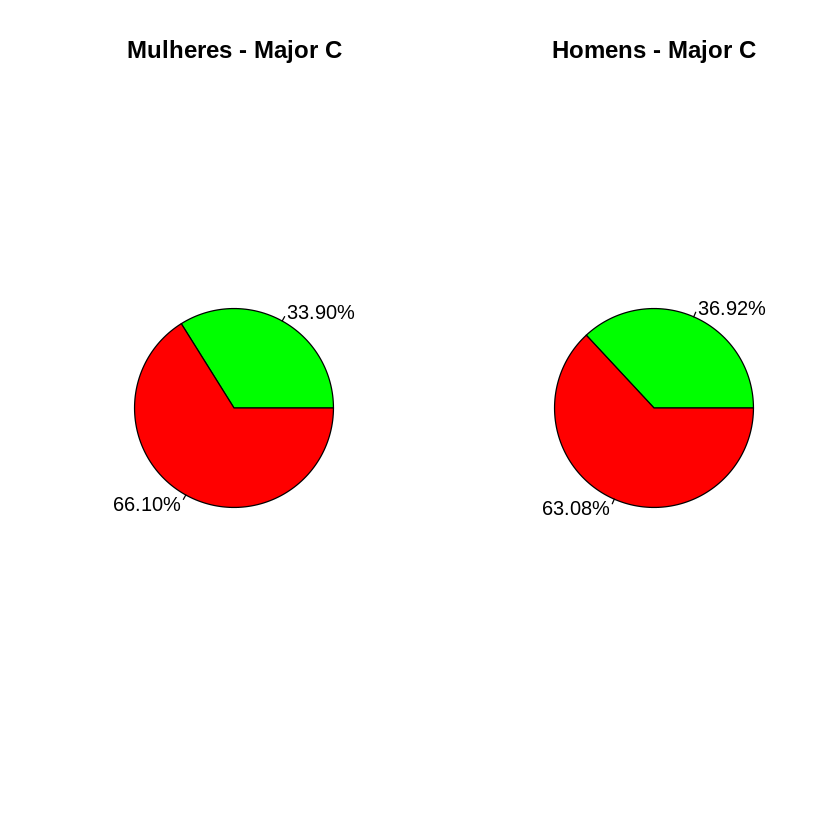


Análise Gráfica do Major C  
---------------------------------


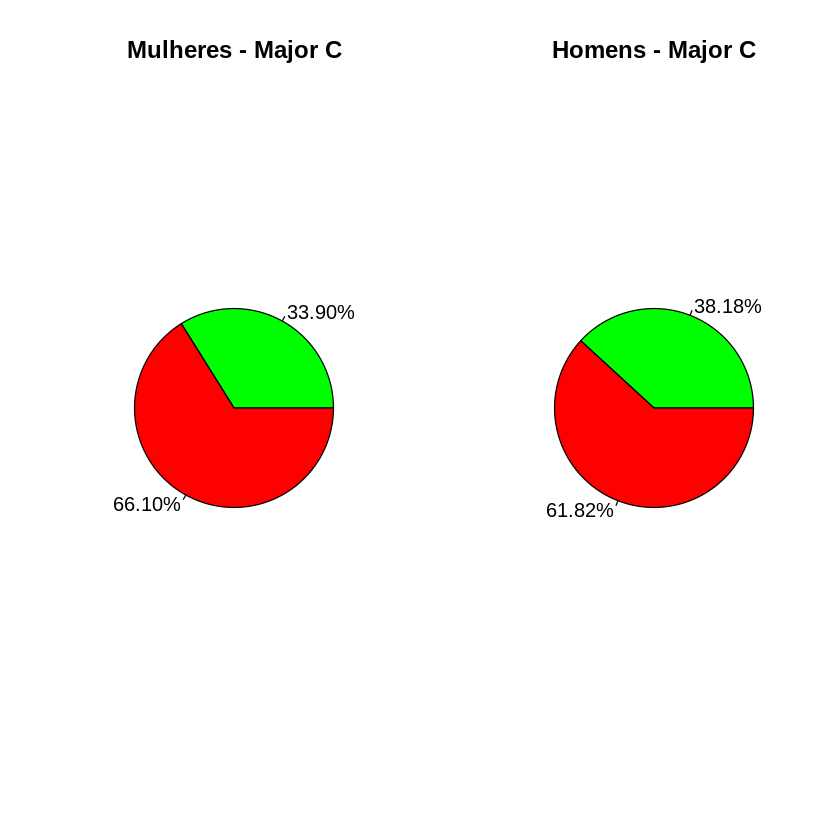

In [160]:
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
pie_major(berkeley,majorstrat)


pie_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')

**Descreva e analise os resultados**

Os resultados estratificados para o Major C apontam que Homens possuem uma taxa de admissão proporcional superior a das Mulheres em torno de 5%, variando dentro dos dados balanceados e do original. Um valor bastante significativo.

## Major D

In [161]:
# Análise numérica

majorstrat <- 'D'

cat('\nAnálise Númerica do Major',majorstrat,' \n')
cat('---------------------------------\n')
analyse_major(berkeley, majorstrat)

cat('\nAnálise Númerica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')
analyse_major(berkeley_bal,majorstrat)


Análise Númerica do Major D  
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
M,M,417,138,279,33.09
F,F,375,131,244,34.93



Análise Númerica do Major D  (Balanceado)
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
F,F,375,131,244,34.93
M,M,208,75,133,36.06



Análise Gráfica do Major D  
---------------------------------


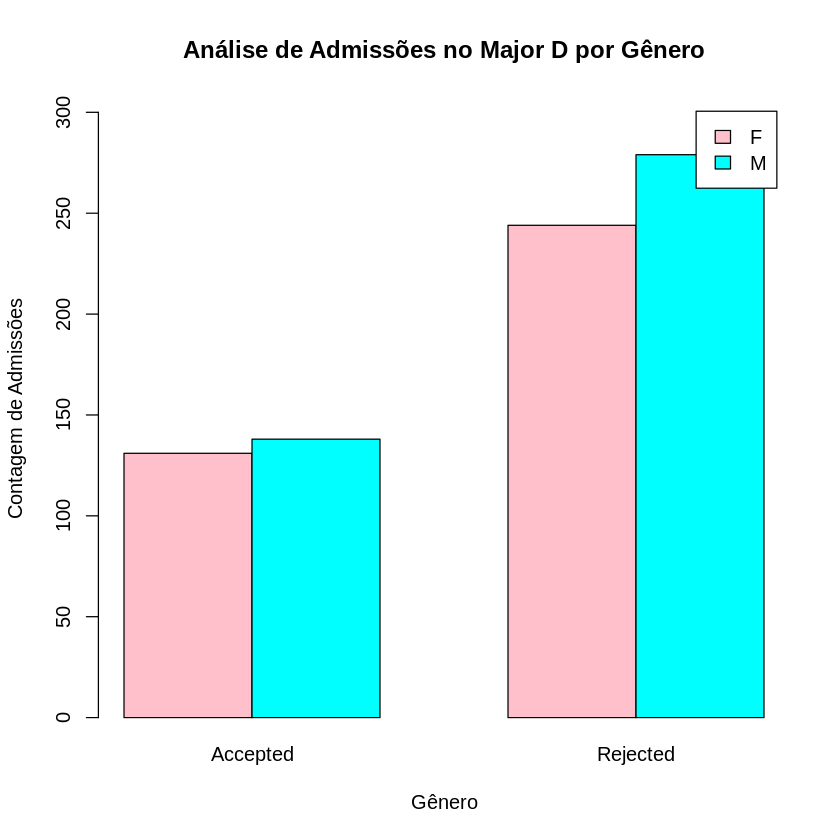


Análise Gráfica do Major D  (Balanceado)
---------------------------------


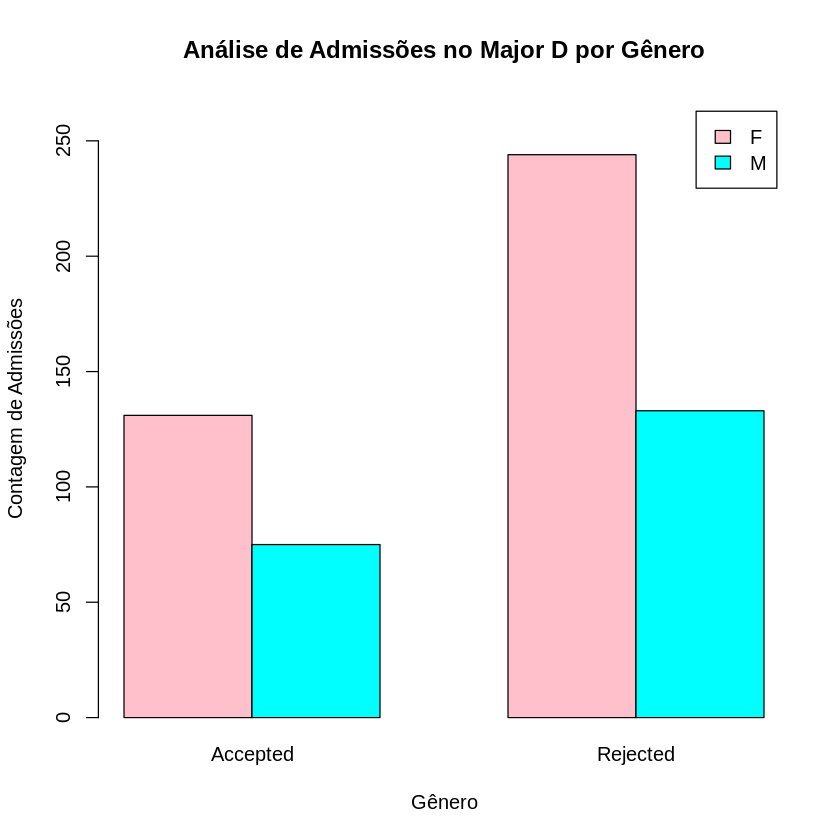

In [162]:
# Análise gráfica

cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
plot_major(berkeley,majorstrat)



plot_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')


Análise Gráfica do Major D  
---------------------------------


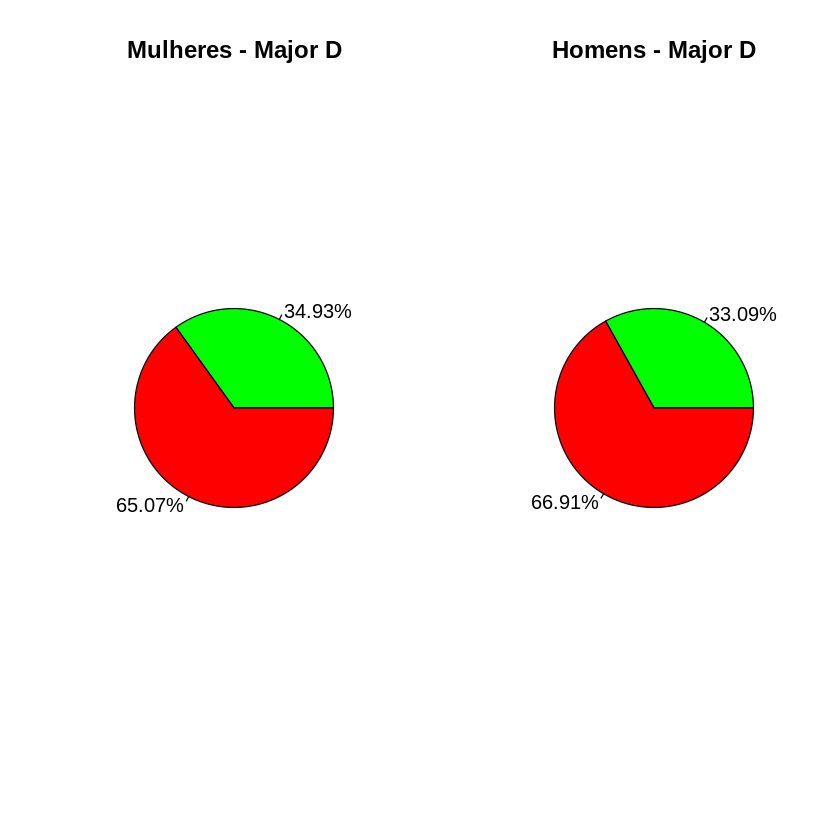


Análise Gráfica do Major D  
---------------------------------


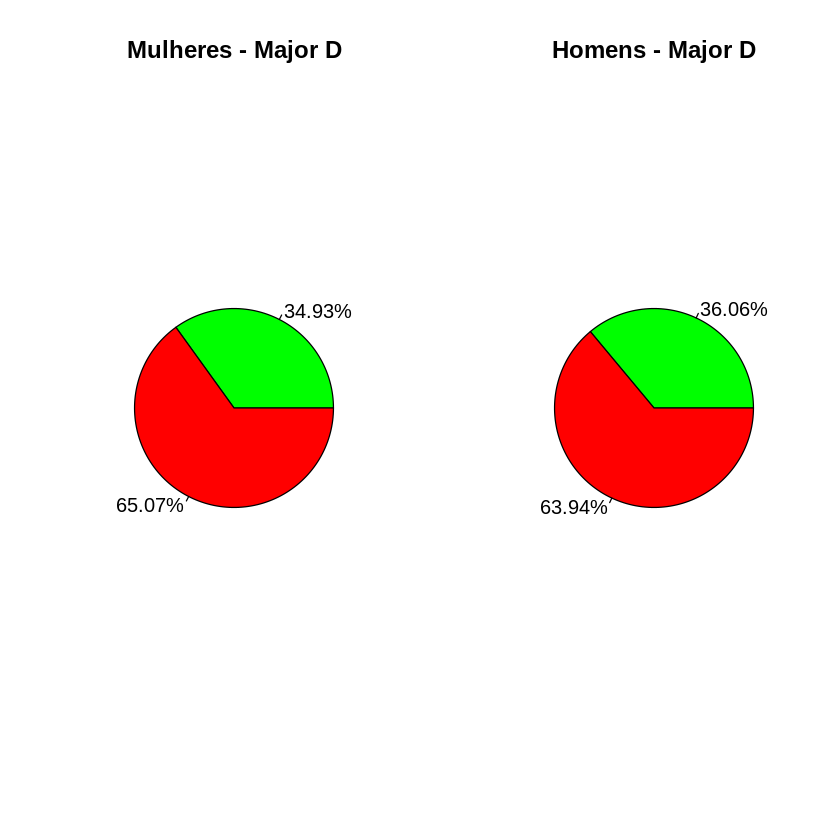

In [163]:
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
pie_major(berkeley,majorstrat)


pie_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')

**Descreva e analise os resultados**

Os resultados estratificados para o Major D apontam que Homens possuem uma taxa de admissão proporcional praticamente idêntica a das Mulheres em torno de 2,5%, variando dentro dos dados balanceados e do original. Um valor estatisticamente insignificante.

## Major E

In [164]:
# Análise numérica

majorstrat <- 'E'

cat('\nAnálise Númerica do Major',majorstrat,' \n')
cat('---------------------------------\n')
analyse_major(berkeley, majorstrat)

cat('\nAnálise Númerica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')
analyse_major(berkeley_bal,majorstrat)


Análise Númerica do Major E  
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
M,M,191,53,138,27.75
F,F,393,94,299,23.92



Análise Númerica do Major E  (Balanceado)
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
F,F,393,94,299,23.92
M,M,101,24,77,23.76



Análise Gráfica do Major E  
---------------------------------


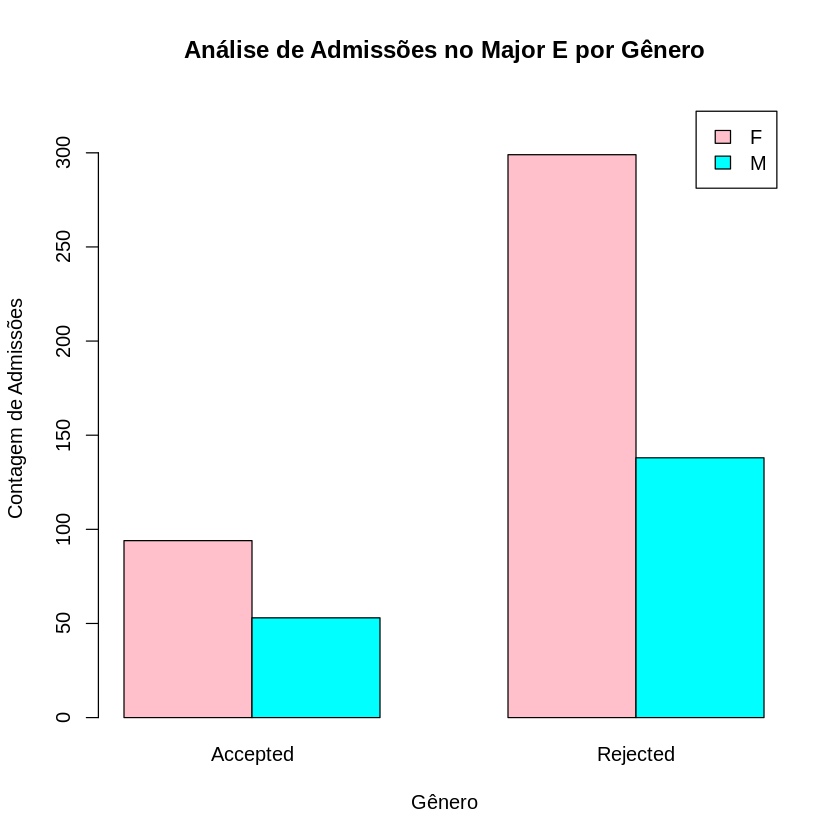


Análise Gráfica do Major E  (Balanceado)
---------------------------------


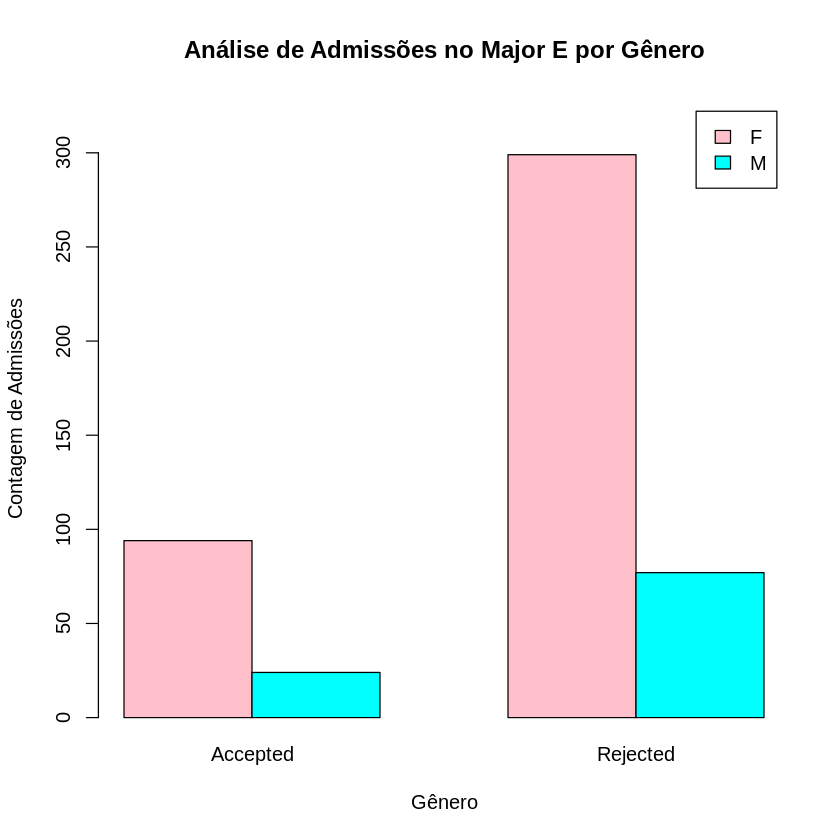

In [165]:
# Análise gráfica

cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
plot_major(berkeley,majorstrat)



plot_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')


Análise Gráfica do Major E  
---------------------------------


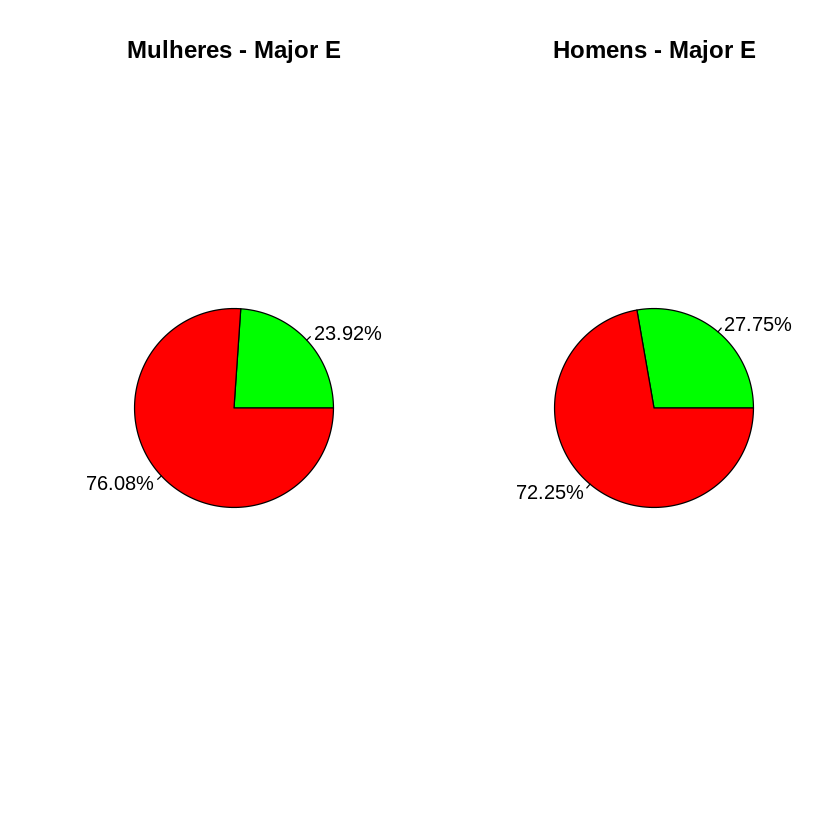


Análise Gráfica do Major E  
---------------------------------


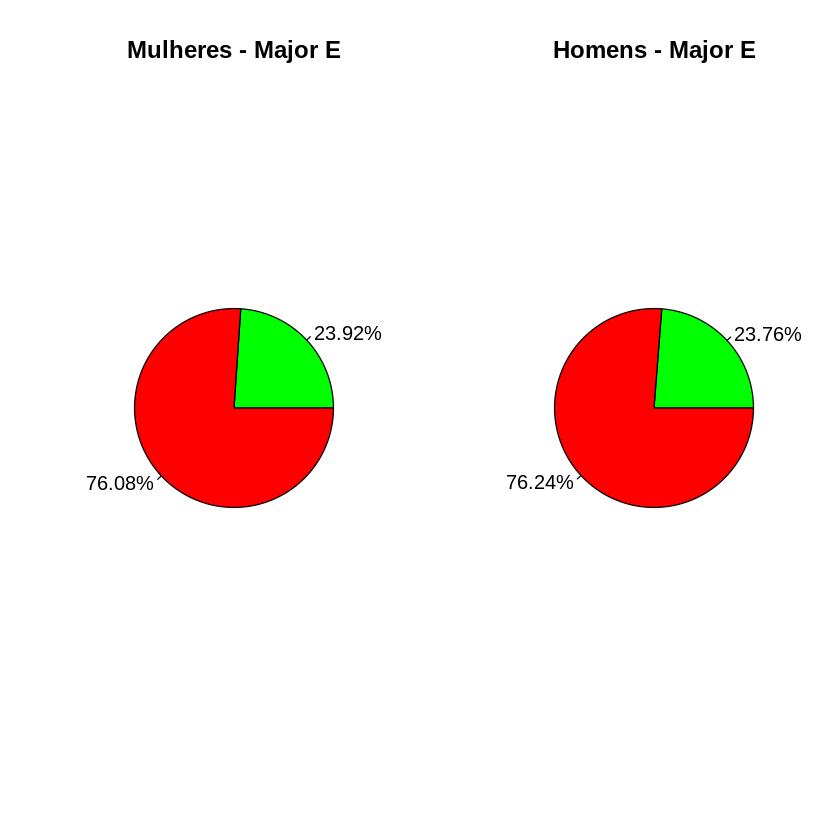

In [166]:
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
pie_major(berkeley,majorstrat)


pie_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')

**Descreva e analise os resultados**

Os resultados estratificados para o Major E apontam que Homens possuem uma taxa de admissão proporcional superior a das Mulheres em torno de 5%, variando dentro dos dados balanceados e do original. Um valor bastante significativo.
Contudo dentro dos dados balanceados, houve uma paridade nas admissões, sendo idênticos estatisticamente. Esses valores podem ser reflexo do tipo de balanceamento utilizado em nosso trabalho.

## Major F

In [167]:
# Análise numérica

majorstrat <- 'F'

cat('\nAnálise Númerica do Major',majorstrat,' \n')
cat('---------------------------------\n')
analyse_major(berkeley, majorstrat)

cat('\nAnálise Númerica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')
analyse_major(berkeley_bal,majorstrat)


Análise Númerica do Major F  
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
F,F,341,25,316,7.33
M,M,373,22,351,5.90



Análise Númerica do Major F  (Balanceado)
---------------------------------


,Gender,Total,Accepted,Rejected,Admission_Rate
,<chr>,<int>,<int>,<int>,<dbl>
F,F,341,25,316,7.33
M,M,210,10,200,4.76



Análise Gráfica do Major F  
---------------------------------


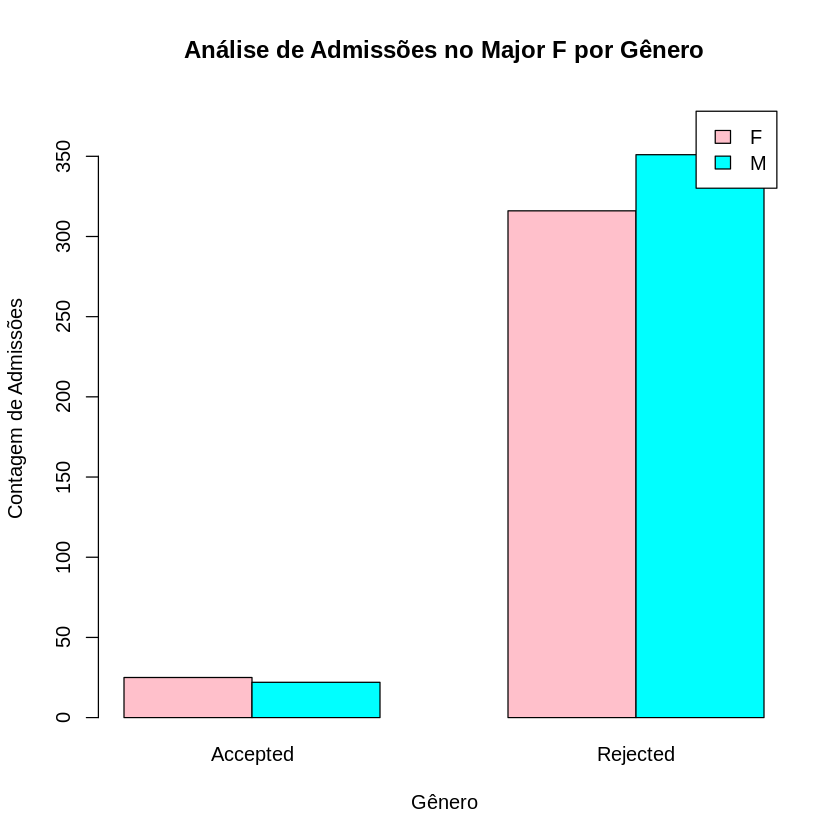


Análise Gráfica do Major F  (Balanceado)
---------------------------------


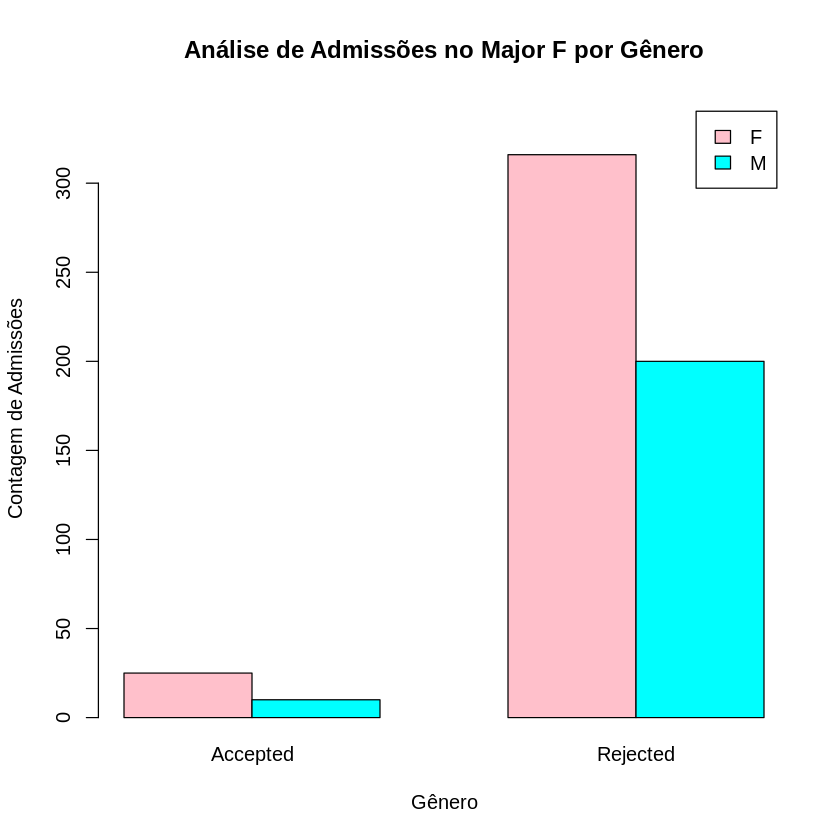

In [168]:
# Análise gráfica

cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
plot_major(berkeley,majorstrat)



plot_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' (Balanceado)\n')
cat('---------------------------------\n')


Análise Gráfica do Major F  
---------------------------------


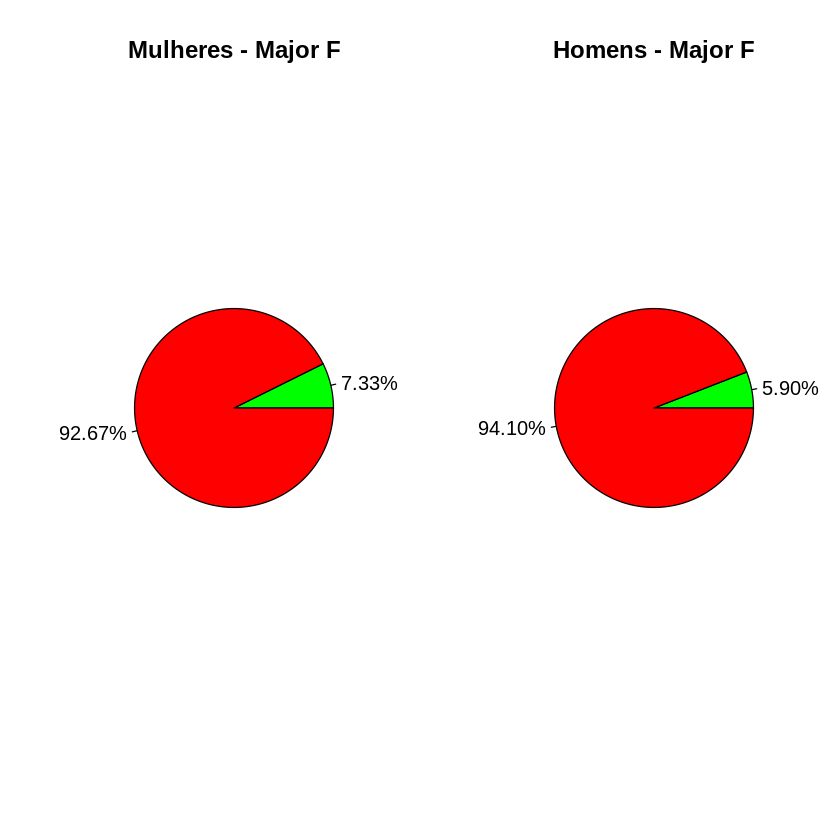


Análise Gráfica do Major F  
---------------------------------


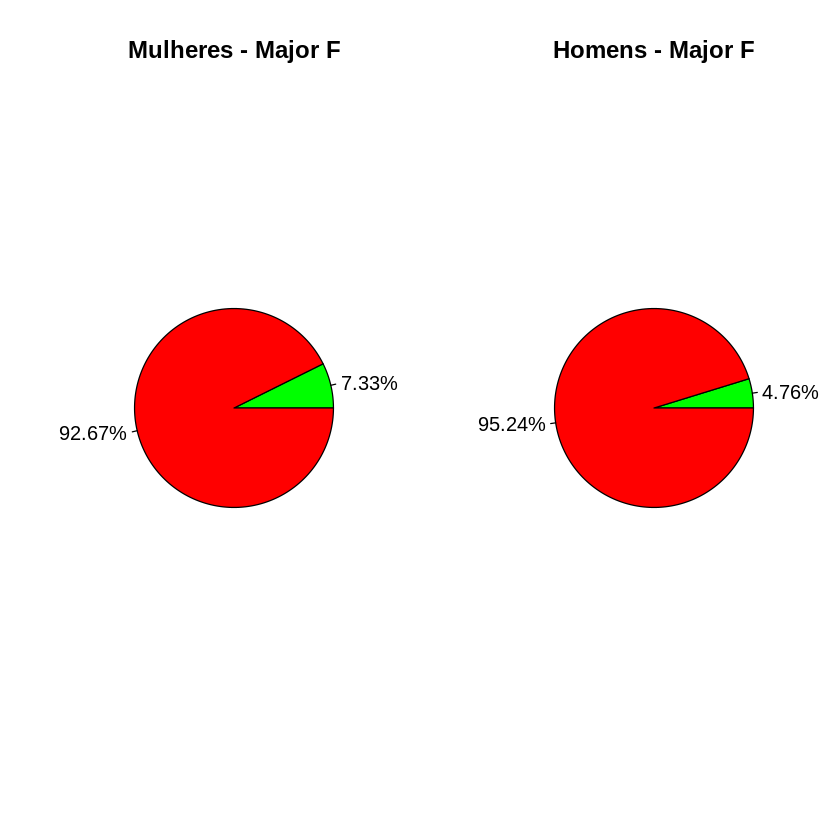

In [169]:
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')
pie_major(berkeley,majorstrat)


pie_major(berkeley_bal,majorstrat)
cat('\nAnálise Gráfica do Major',majorstrat,' \n')
cat('---------------------------------\n')

**Descreva e analise os resultados**

Os resultados estratificados para o Major F apontam que Homens possuem uma taxa de admissão proporcional praticamente idêntica a das Mulheres em torno de 2,5% (com uma leve margem de vantagem para as mulheres) variando dentro dos dados balanceados e do original. Um valor ainda sim estatisticamente insignificante.

In [170]:
# Dados tabulares agrupados

cat('\nTabela Geral dos Estratos de Major\n')
cat('------------------------------------------\n')
Major_table(berkeley)

cat('\nTabela Geral dos Estratos de Major (Balanceado)\n')
cat('------------------------------------------\n')
Major_table(berkeley_bal)


Tabela Geral dos Estratos de Major
------------------------------------------


Major,Gender,Total,Accepted,Rejected,Admission_Rate
<chr>,<chr>,<int>,<int>,<int>,<dbl>
A,F,108,89,19,82.41
A,M,1138,825,313,72.50
B,F,25,17,8,68.00
B,M,560,353,207,63.04
C,F,593,201,392,33.90
C,M,325,120,205,36.92
D,F,375,131,244,34.93
D,M,417,138,279,33.09
E,F,393,94,299,23.92



Tabela Geral dos Estratos de Major (Balanceado)
------------------------------------------


Major,Gender,Total,Accepted,Rejected,Admission_Rate
<chr>,<chr>,<int>,<int>,<int>,<dbl>
A,F,108,89,19,82.41
A,M,565,421,144,74.51
B,F,25,17,8,68.00
B,M,301,184,117,61.13
C,F,593,201,392,33.90
C,M,165,63,102,38.18
D,F,375,131,244,34.93
D,M,208,75,133,36.06
E,F,393,94,299,23.92


## Conclusão

**Apresente os principais resultados, assim como a resposta e a justificativa quanto à possível existência do Paradoxo de Simpson neste dataset.**

Concluímos que existem diferenças notáveis entre as análises das amostra total e estratificada das admissões. Inicialmente, observamos uma diferença significativa nas admissões de mulheres e homens na universidade. No entanto, uma inspeção mais detalhada, segmentada por Major, revelou alguns detalhes interessantes. Em alguns Majors, as mulheres superam os homens, em outros é o oposto, e há áreas onde as diferenças são mínimas. Notavelmente, muitas mulheres se candidatam a Majors com taxas de admissão mais baixas, e sua presença proporcionalmente menor nesses campos contribui para a distorção percebida na análise da amostra total.

Esses achados exemplificam o Paradoxo de Simpson, onde a relação aparente entre variáveis pode mudar ou até mesmo inverter ao segmentar os dados em grupos específicos. Isso sublinha a necessidade de uma análise cuidadosa, considerando todas as variáveis e suas possíveis interações, para evitar interpretações equivocadas.